## Get size class distribution

This script imports aggregated output and then displays size class distribution for a subset of ensemble members.

The subset can be determined from the aggreagated data.

In [1]:
import pandas as pd
import glob
import os
import netCDF4 as nc4
import sys
sys.path.append('/glade/u/home/adamhb/Earth-System-Model-Tools')
from fields import fields
from constants import pft_colors
import esm_tools
from esm_tools import m2_per_ha
import re
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
np.set_printoptions(threshold=1000)
import seaborn as sns
import importlib
importlib.reload(esm_tools)

<module 'esm_tools' from '/glade/u/home/adamhb/Earth-System-Model-Tools/esm_tools.py'>

## Functions

In [59]:
# def get_scls_dist_fig(df,tag,add_):
#     df = df.copy()
#     df = df.loc[df['inst_tag'] == tag]
#     df['Group'] = "fates"
#     obs = pd.read_csv('/glade/u/home/adamhb/scls.csv')
#     df = pd.concat([df,obs],axis = 0)
#     bins = [5, 20, 40, 60, 80, 100, 120, float('inf')]
#     labels = ['5-20', '20-40', '40-60', '60-80', '80-100', '100-120', '>120']
#     # Create a new column for binned size classes
#     df['new_size_class'] = pd.cut(df['size_class'], bins=bins, labels=labels, right=False, include_lowest=True)
#     df = df.groupby(['Group','new_size_class']).sum()['density'].reset_index()
#     sns.barplot(x='new_size_class', y='density', hue='Group', data=df, linewidth=2.5)

#     # Adding titles and labels
#     plt.title('1870 size class dist. \n Ensemble member {}'.format(peas_tag_map[int(tag)]))
#     plt.xlabel('Size Class [cm dbh]')
#     plt.ylabel('Density [N ha-1]')
#     #plt.ylim(0, 100)
    
#     # Adding a legend if not automatically included
#     plt.legend(title='Mod vs. Obs')
    
#     # Display the plot
#     #file_path = f'/glade/u/home/adamhb/after_logging/{tag}.png'
#     #plt.savefig(file_path)
#     plt.show()

# def get_scls_dist_no_obs_one_inst(df,tag_numbers,add_peas_obs = False):
#     df = df.copy()
#     df = df.loc[df['inst_tag'] == tag]
#     df['Group'] = "fates"
#     #obs = pd.read_csv('/glade/u/home/adamhb/scls.csv')
#     #df = pd.concat([df,obs],axis = 0)
#     bins = [5, 20, 40, 60, 80, 100, 120, float('inf')]
#     labels = ['5-20', '20-40', '40-60', '60-80', '80-100', '100-120', '>120']
#     # Create a new column for binned size classes
#     df['new_size_class'] = pd.cut(df['size_class'], bins=bins, labels=labels, right=False, include_lowest=True)
#     df = df.groupby('new_size_class').sum()['density'].reset_index()
#     ax = sns.barplot(x='new_size_class', y='density', data=df, linewidth=2.5)
#     #sns.barplot(x='new_size_class', y='density', data=df, linewidth=2.5)
#     for patch in ax.patches:
#         patch.set_facecolor('white')
#         patch.set_edgecolor('black')
#         patch.set_linewidth(2.5)

#     # Adding titles and labels
#     plt.title('2015 size class dist. \n Ensemble member {}'.format(f1870_to_2015_tag_map[int(tag)]))
#     plt.xlabel('Size Class [cm dbh]')
#     plt.ylabel('Density [N ha-1]')
#     #plt.ylim(0, 100)
    
#     # Adding a legend if not automatically included
#     #plt.legend(title='Mod vs. Obs')
    
#     # Display the plot
#     #file_path = f'/glade/u/home/adamhb/after_logging/{tag}.png'
#     #plt.savefig(file_path)
#     plt.show()

def rebin(df):
    df = df.copy()
    bins = [5, 20, 40, 60, 80, 100, 120, float('inf')]
    labels = ['5-20', '20-40', '40-60', '60-80', '80-100', '100-120', '>120']
    # Create a new column for binned size classes
    df['size_class'] = pd.cut(df['fates_levscls'], bins=bins, labels=labels, right=False, include_lowest=True)
    df = df.groupby(['harmonized_tag','pft_name','size_class']).sum()['n_per_ha'].reset_index()
    return df

def get_size_class_distribution_data(case_name,years,tag_numbers,tag_map,
                                     metric = "density", plot = False,by_pft = True, dbh_min = 5,
                                     model_output_root = '/glade/derecho/scratch/adamhb'):
    pft_map = {1:"pine",2:"cedar",3:"fir",4:'shrub',5:'oak'}
    
    inst_tags = esm_tools.inst_to_tag(tag_numbers)
    output = pd.DataFrame()

    for i,tag_number in enumerate(tag_numbers):
        ds = esm_tools.load_fates_output_data(model_output_root=model_output_root,
                                              case_name = case_name,
                                              years = years,
                                              fields = fields,
                                              inst_tag = inst_tags[i],
                                              manual_path = None)

        if metric == "ba":
            fates_var = 'FATES_BASALAREA_SZPF'
        if metric == "density":
            fates_var = 'FATES_NPLANT_SZPF'

        # xarr = esm_tools.scpf_to_scls_by_pft(ds[fates_var], ds).mean(dim = "time").\
        #                  sel(fates_levpft = slice(0,3)).sel(fates_levscls = slice(5,None))
        
        xarr = esm_tools.scpf_to_scls_by_pft(ds[fates_var], ds).mean(dim = "time").\
                          isel(fates_levpft = [0,1,2,4]).sel(fates_levscls = slice(dbh_min,None))
        
        if by_pft == False:
            xarr = xarr.sum(dim = 'fates_levpft')

        df = xarr.to_dataframe(name='density').reset_index()
        df['n_per_ha'] = df['density'] * m2_per_ha
        df['tag_number'] = tag_number

        if by_pft == True:
            df['pft_name'] = df['fates_levpft'].map(pft_map)
        output = pd.concat([output,df],axis = 0)

    output['harmonized_tag'] = output['tag_number'].map(tag_map)
    return output


def plot_size_class_dist(df,desired_pft_order = ['pine','cedar','fir','oak']):
    pft_colors = ["sandybrown","forestgreen","gold","brown"]
    df = df.copy()
    sns.set(style="whitegrid")  # Optional: for better aesthetics
    
    df = rebin(df)
    
    pft_colors = {'pine': 'blue', 'cedar': 'green', 'fir': 'red', 'shrub': 'orange','oak': 'orange'}
    
    colors = [pft_colors[pft] for pft in desired_pft_order]
    
    # Pivot the data
    df_pivot = df.pivot_table(index=[['harmonized_tag', 'size_class']+desired_pft_order], columns='pft_name', values='n_per_ha', aggfunc='sum', fill_value=0)
    df_pivot = df_pivot.reset_index()
    df_pivot
    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=len(df['harmonized_tag'].unique()), figsize=(15, 6), sharey=True)
    
    tag_numbers = df['harmonized_tag'].unique()
    pfts = df['pft_name'].unique()
    
    for i, tag in enumerate(tag_numbers):
        ax = axes[i]
        df_subset = df_pivot[df_pivot['harmonized_tag'] == tag]
        bars = df_subset.set_index('size_class')[pfts].plot(kind='bar', stacked=True, ax=ax, legend=(i == 0), color = pft_colors)
        ax.set_title(f'Ensemble Member {tag}')
        ax.set_xlabel('Size class [cm]')
        ax.set_ylabel('Stem density [ha-1]' if i == 0 else '')
        if i == 0:
            ax.legend(title='PFT')
        # Add dark border to each bar
        for container in bars.containers:
            for bar in container:
                bar.set_edgecolor('black')
                bar.set_linewidth(1.5)
    plt.tight_layout()
    plt.show()

def plot_size_class_dist(df, desired_pft_order=['pine', 'cedar', 'fir', 'oak']):
    pft_colors = {'pine':'gold','cedar':'sandybrown','fir':'forestgreen','oak':'brown'}
    df = df.copy()
    sns.set(style="whitegrid")  # Optional: for better aesthetics

    # Assuming `rebin` is a function that processes your data
    df = rebin(df)

    # Ensure the colors are in the correct order
    colors = [pft_colors[pft] for pft in desired_pft_order]

    # Pivot the data
    df_pivot = df.pivot_table(index=['harmonized_tag', 'size_class'], columns='pft_name', values='n_per_ha', aggfunc='sum', fill_value=0)
    df_pivot = df_pivot.reset_index()

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=len(df['harmonized_tag'].unique()), figsize=(15, 6), sharey=True)

    tag_numbers = df['harmonized_tag'].unique()

    for i, tag in enumerate(tag_numbers):
        ax = axes[i]
        df_subset = df_pivot[df_pivot['harmonized_tag'] == tag]
        bars = df_subset.set_index('size_class')[desired_pft_order].plot(kind='bar', stacked=True, ax=ax, legend=(i == 0), color=colors)
        ax.set_title(f'Ensemble Member {tag}')
        ax.set_xlabel('Size class [cm]')
        ax.set_ylabel('Stem density [ha-1]' if i == 0 else '')
        #ax.set_yscale('log')
        if i == 0:
            ax.legend(title='PFT')

        # Add dark border to each bar
        for container in bars.containers:
            for bar in container:
                bar.set_edgecolor('black')
                bar.set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

# Example call to the function (assuming scls_data_peas and ds are defined)
# plot_size_class_dist(df)

In [52]:
 ds = esm_tools.load_fates_output_data(model_output_root='/glade/derecho/scratch/adamhb',
                                              case_name = 'equilibrium_700yrs_050924_01_-17e2acb6a_FATES-1449c787',
                                              years = [1868,1869],
                                              fields = fields,
                                              inst_tag = "0061",
                                              manual_path = None)

-- your data have been read in -- 


In [58]:
ds2 = esm_tools.scpf_to_scls_by_pft(ds.FATES_NPLANT_SZPF, ds)
ds2.isel(fates_levpft = [0,1,2,4 

<xarray.DataArray 'FATES_NPLANT_SZPF' (time: 24, fates_levpft: 5,
                                       fates_levscls: 13)>
dask.array<getitem, shape=(24, 5, 13), dtype=float32, chunksize=(1, 5, 13), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) object 1868-01-01 00:00:00 ... 1869-12-01 00:00:00
  * fates_levscls  (fates_levscls) float32 0.0 5.0 10.0 15.0 ... 80.0 90.0 100.0
  * fates_levpft   (fates_levpft) int32 1 2 3 4 5
Attributes:
    long_name:      stem number density by pft/size
    units:          m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

In [34]:
f1870_to_2015_tag_map = {41:1,60:2,65:3,73:4,75:5}
SSP3_TREATED_tag_map = f1870_to_2015_tag_map
SSP3_no_treat_tag_map = {41:1,60:2,64:3,72:4,74:5}

### Make size class distribution figures in 1870

Need to add obs and take out oaks

-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 


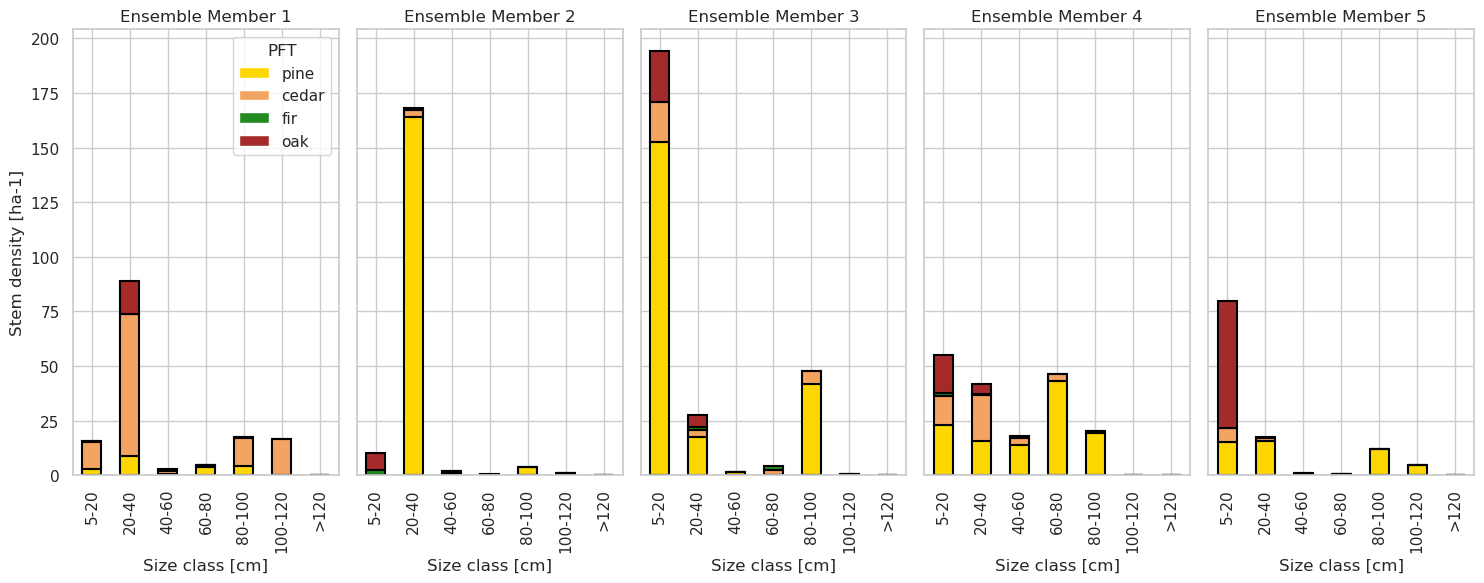

In [60]:
peas_tag_map = {42:1,61:2,66:3,74:4,76:5}
peas_case_name = 'equilibrium_700yrs_050924_01_-17e2acb6a_FATES-1449c787'
peas_case_years = [1865,1869]
peas_tag_numbers =  [42,61,66,74,76]

scls_data_peas = get_size_class_distribution_data(case_name=peas_case_name,
                                                  years = peas_case_years,
                                                  tag_numbers=peas_tag_numbers,
                                                  tag_map = peas_tag_map,
                                                  metric = "density", by_pft=True, dbh_min=10)

plot_size_class_dist(scls_data_peas)

### Make size class distribution figures in 2015

-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 


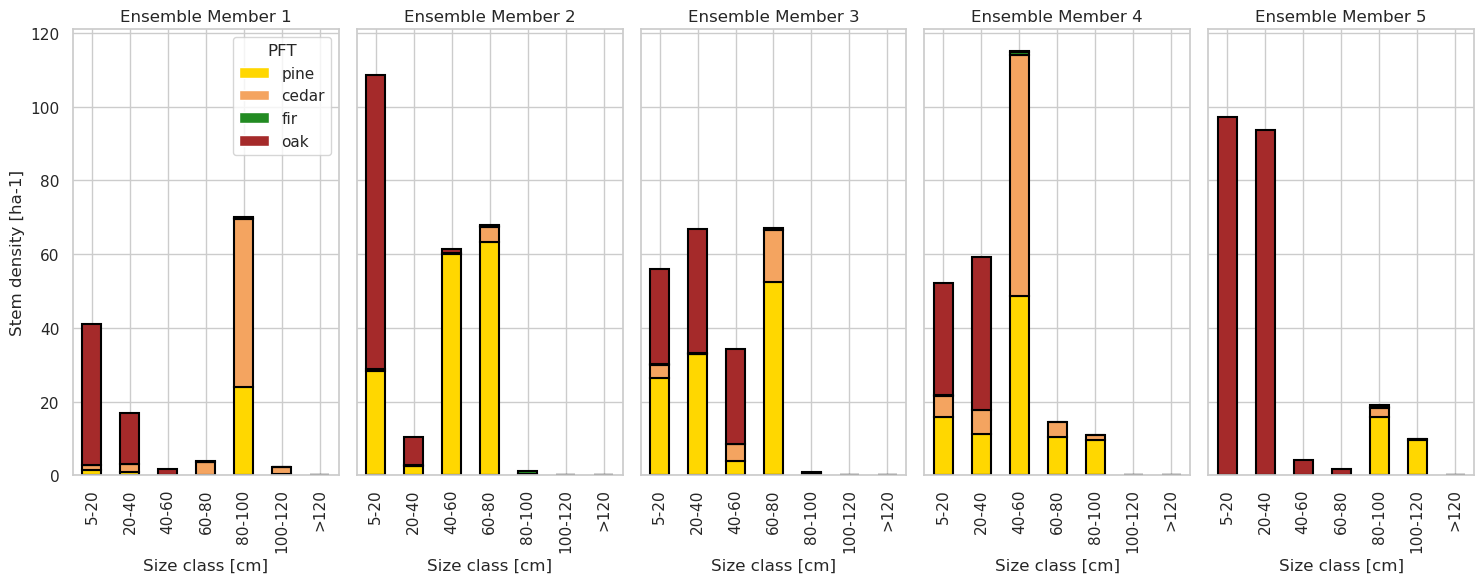

In [61]:
early21st_case_name = 'supIg_1.25_051424-1951-2020_-17e2acb6a_FATES-1449c787'
early21st_years = [2010,2014]
early21st_tag_numbers = [41,60,65,73,75]

scls_data_2015 = get_size_class_distribution_data(case_name=early21st_case_name,
                                                  years = early21st_years,
                                                  tag_numbers=early21st_tag_numbers,
                                                  tag_map = f1870_to_2015_tag_map,
                                                  metric = "density", by_pft=True, dbh_min=10)

plot_size_class_dist(scls_data_2015)

-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 


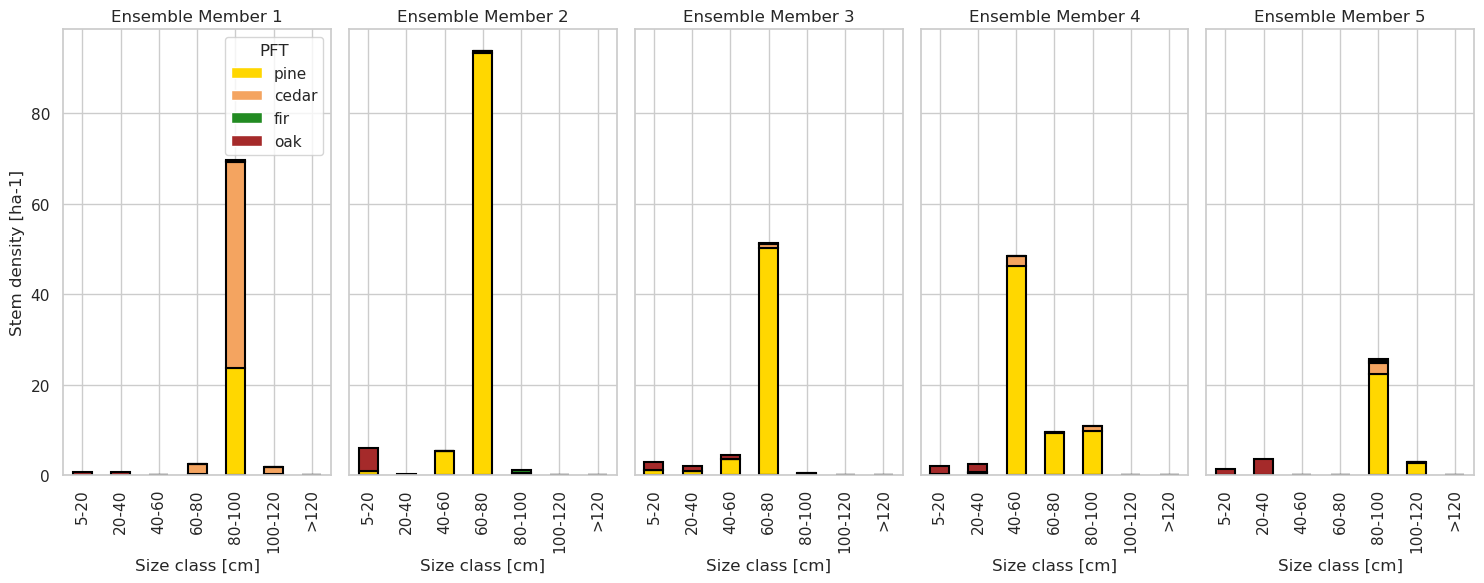

In [62]:
early21st_case_name = 'supIg_1.25_051424-2015-2098-TREATED_-17e2acb6a_FATES-1449c787'
early21st_years = [2015,2016]
early21st_tag_numbers = [41,60,65,73,75]
f1870_to_2015_tag_map = {41:1,60:2,65:3,73:4,75:5}
SSP3_TREATED_tag_map = f1870_to_2015_tag_map

scls_data_2015 = get_size_class_distribution_data(case_name=early21st_case_name,
                                                  years = early21st_years,
                                                  tag_numbers=early21st_tag_numbers,
                                                  tag_map = SSP3_TREATED_tag_map,
                                                  metric = "density", by_pft=True, dbh_min=10)

plot_size_class_dist(scls_data_2015)

In [106]:
scls_data_peas.to_dataframe(name='density').reset_index()

,fates_levpft,fates_levscls,density
0,1,5.0,9.402906e-03
1,1,10.0,2.953265e-04
2,1,15.0,0.000000e+00
3,1,20.0,7.007334e-04
4,1,30.0,2.020705e-04
5,1,40.0,1.584995e-05
6,1,50.0,6.022079e-05
7,1,60.0,0.000000e+00
8,1,70.0,3.572026e-04
9,1,80.0,2.792613e-04


In [84]:
scls_data_21st = esm_tools.get_size_class_distribution(case_name=early21st_case_name,
                                                  years = early21st_years,
                                                  metric = "density",
                                                  plot = False,
                                                  tag_numbers = early21st_tag_numbers, by_pft=False)

-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 


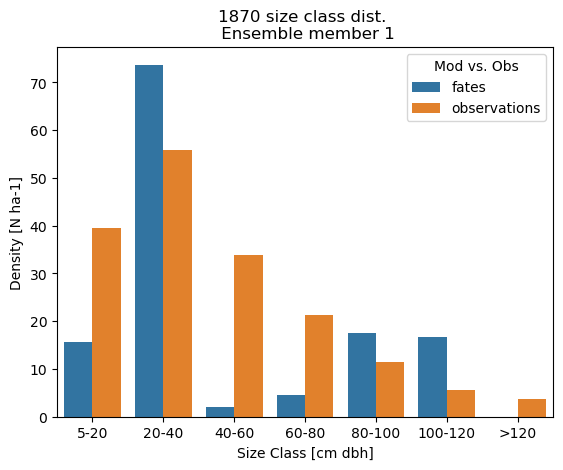

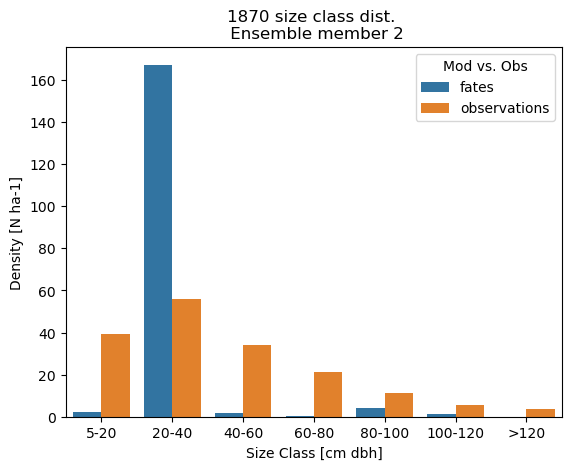

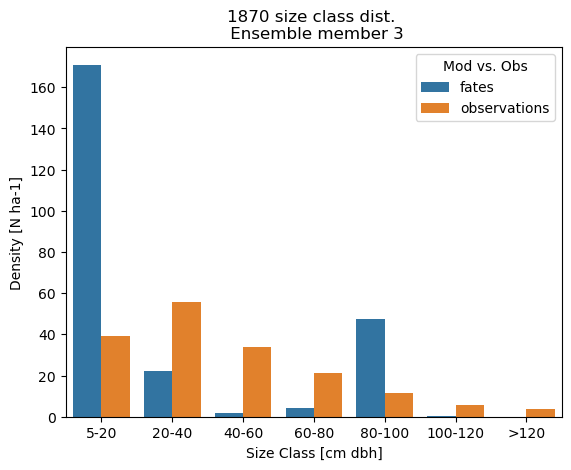

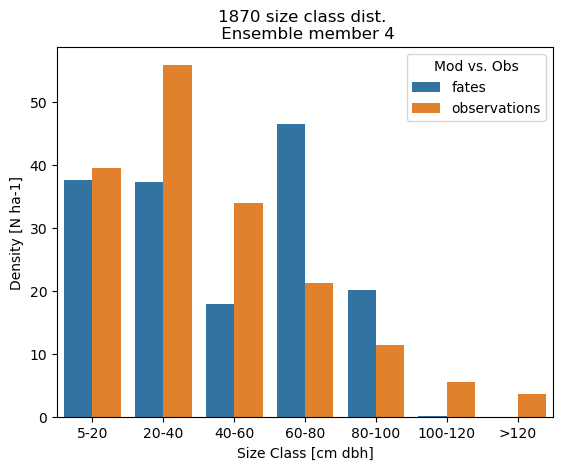

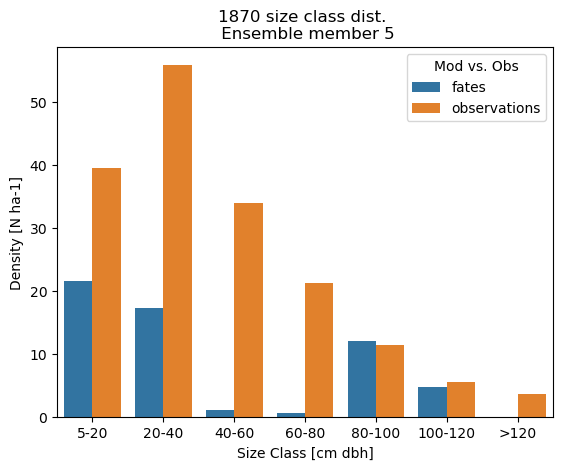

In [57]:
for tag in peas_tag_numbers: 
    get_scls_dist_one_inst(scls_data_peas,tag)

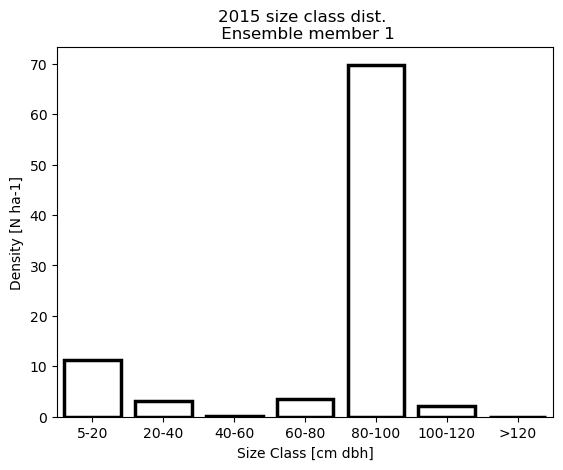

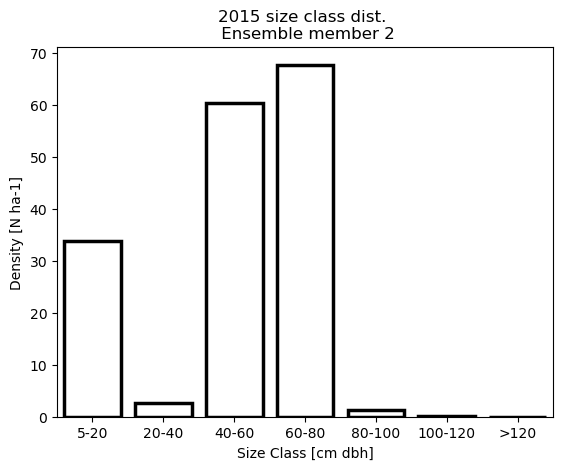

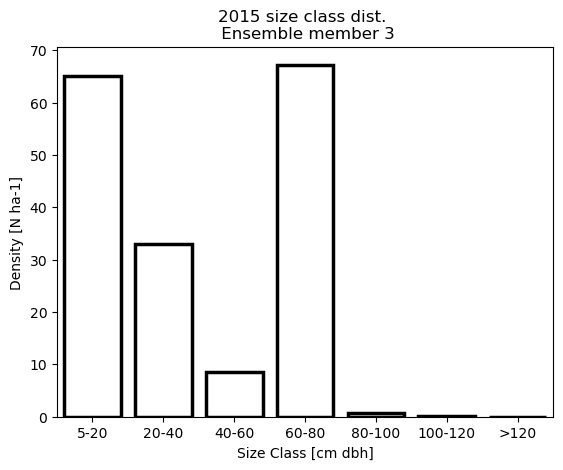

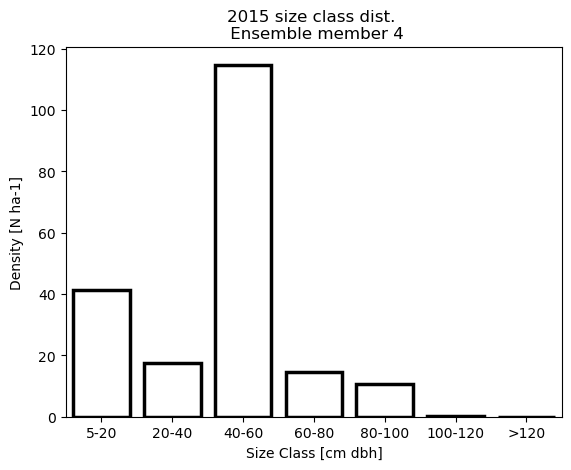

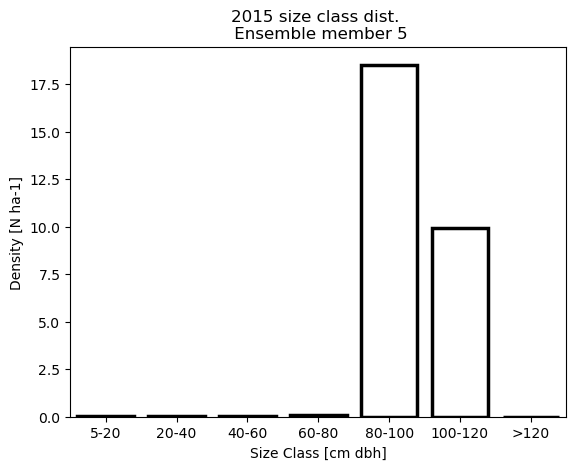

In [89]:
for tag in early21st_tag_numbers: 
    get_scls_dist_no_obs_one_inst(scls_data_21st,tag)

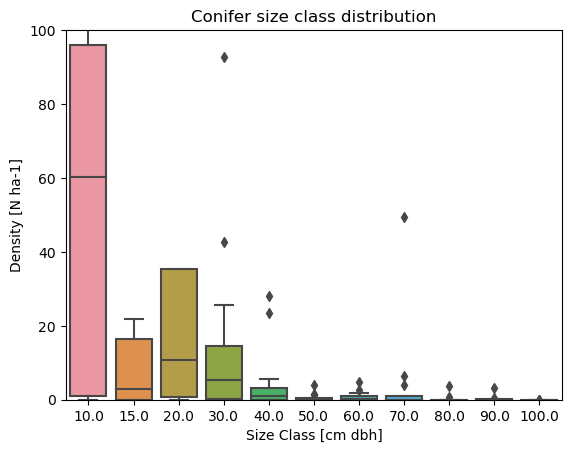

In [18]:
sns.boxplot(x='size_class', y='density', data=scls_data)

# Adding titles and labels (optional)
plt.title('Conifer size class distribution')
plt.xlabel('Size Class [cm dbh]')
plt.ylabel('Density [N ha-1]')
plt.ylim(0, 100)

# Display the plot
plt.show()